In [81]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

# Task 1

In [120]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [121]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [122]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [85]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):
    pass
    # loss_term = bernoulli loss between true x and predicted x_decoded

    # KL_term = KL divergence between normal with params z_mean, z_log_var and standard multivariate normal

    # return tf.reduce_mean(loss_term - KL_term)

In [86]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [87]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # epsilon = sample from standard normal distribution (sample batch observation from dim dimensional normal distribution)
        return # transform epsilon so it becomes from the normal distribution with params z_mean, z_log_var

In [88]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [89]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 dense_30 (Dense)            (None, 256)                  200960    ['input_13[0][0]']            
                                                                                                  
 dense_31 (Dense)            (None, 256)                  65792     ['dense_30[0][0]']            
                                                                                                  
 z_mean (Dense)              (None, 10)                   2570      ['dense_31[0][0]']            
                                                                                            

In [90]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [91]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_32 (Dense)            (None, 256)               2816      
                                                                 
 dense_33 (Dense)            (None, 256)               65792     
                                                                 
 dense_34 (Dense)            (None, 784)               201488    
                                                                 
Total params: 270096 (1.03 MB)
Trainable params: 270096 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## e)

In [92]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [93]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 3s 6ms/step - loss: 225.9298
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 142.2830
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 126.8535
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 120.7394
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 116.7550
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 114.4075
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 112.5377
Epoch 8/10
469/469 [==============================] - 3s 7ms/step - loss: 111.0167
Epoch 9/10
469/469 [==============================] - 3s 6ms/step - loss: 109.9672
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 109.1301


## f)

In [94]:
# representation in the latent space of observations from test ds
z_test_pred = vae.encoder.predict(x_test)

313/313 [==============================] - 0s 939us/step


In [95]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = vae.decoder.predict(z_test_pred[2]) # decoder predictions - we take a vector from the latent space and transform it to be again a picture

313/313 [==============================] - 0s 758us/step


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

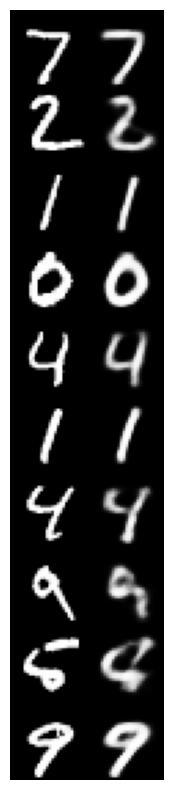

In [97]:
n = 10
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [98]:
# use z_test_pred

In [99]:
from sklearn.manifold import TSNE

In [100]:
tsne = TSNE(n_components=2)

In [101]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

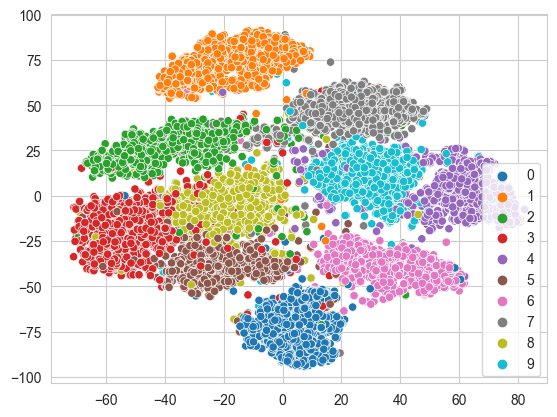

In [102]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

h)

In [103]:
p_z = np.random.multivariate_normal(np.zeros(10),np.diag(np.ones(10)), 10)

p_z_decoded = vae.decoder.predict(p_z)

1/1 [==============================] - 0s 10ms/step


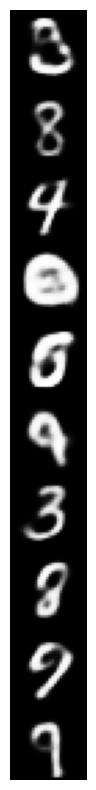

In [104]:
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n,digit_size))
for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size,:] = p_z_decoded[i, :].reshape(digit_size, digit_size)
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

# Task 2 

In [131]:
latent_dim = 10

#encoder
encoder_inputs = keras.Input(shape=(original_dim + 1,))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
cvae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
cvae_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 785)]                0         []                            
                                                                                                  
 dense_40 (Dense)            (None, 256)                  201216    ['input_17[0][0]']            
                                                                                                  
 dense_41 (Dense)            (None, 256)                  65792     ['dense_40[0][0]']            
                                                                                                  
 z_mean (Dense)              (None, 10)                   2570      ['dense_41[0][0]']            
                                                                                            

In [132]:
#decoder
latent_inputs = keras.Input(shape=(latent_dim+1,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
cvae_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
cvae_decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 11)]              0         
                                                                 
 dense_42 (Dense)            (None, 256)               3072      
                                                                 
 dense_43 (Dense)            (None, 256)               65792     
                                                                 
 dense_44 (Dense)            (None, 784)               201488    
                                                                 
Total params: 270352 (1.03 MB)
Trainable params: 270352 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [133]:
class cVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            c = data[:,-1]
            c = tf.reshape(c, (-1, 1))
            x = data[:,:-1]
            reconstruction = self.decoder(tf.concat([z, c], axis=1))
            total_loss = -elbo_vae(x, reconstruction, z_mean, z_log_var)           
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}     

In [137]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train = np.concatenate([x_train,y_train.reshape(-1,1)],axis=1)
x_test = np.concatenate([x_test,y_test.reshape(-1,1)],axis=1)

In [138]:
cvae = cVAE(cvae_encoder, cvae_decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
cvae.fit(x_train, epochs=25, batch_size=128)

Epoch 1/25
469/469 [==============================] - 3s 7ms/step - loss: 219.2536
Epoch 2/25
469/469 [==============================] - 3s 7ms/step - loss: 141.3312
Epoch 3/25
469/469 [==============================] - 3s 7ms/step - loss: 127.5425
Epoch 4/25
469/469 [==============================] - 3s 7ms/step - loss: 121.6176
Epoch 5/25
469/469 [==============================] - 5s 11ms/step - loss: 117.8246
Epoch 6/25
469/469 [==============================] - 3s 6ms/step - loss: 115.5939
Epoch 7/25
469/469 [==============================] - 3s 6ms/step - loss: 113.7161
Epoch 8/25
469/469 [==============================] - 3s 7ms/step - loss: 111.8573
Epoch 9/25
469/469 [==============================] - 3s 7ms/step - loss: 110.8736
Epoch 10/25
469/469 [==============================] - 3s 6ms/step - loss: 109.3990
Epoch 11/25
469/469 [==============================] - 3s 6ms/step - loss: 108.5599
Epoch 12/25
469/469 [==============================] - 4s 8ms/step - loss: 107.8709


In [139]:
z_test_pred = cvae.encoder.predict(x_test)[-1]
z_test_pred = np.concatenate([z_test_pred, y_test.reshape(-1,1)],axis=1)
test_pred = cvae.decoder.predict(z_test_pred)

313/313 [==============================] - 0s 735us/step


In [140]:
x_test = x_test[:,:-1]
x_test.shape

(10000, 784)

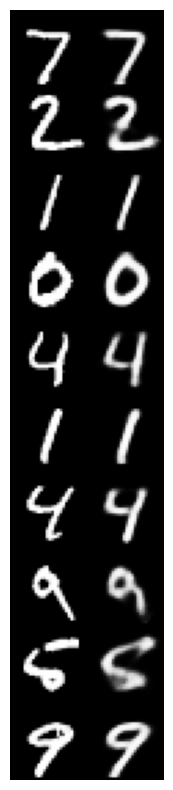

In [141]:
n = 10
digit_size = 28
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


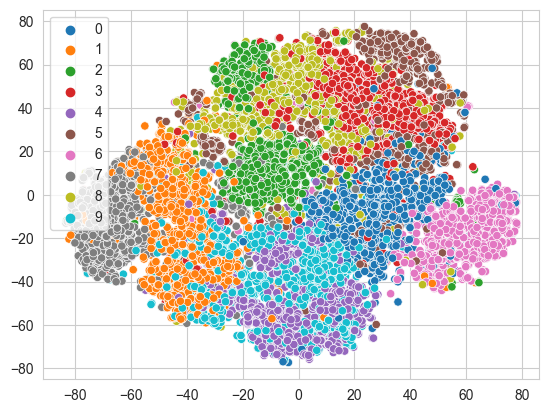

In [142]:
tsne = TSNE(n_components=2)
z_test_pred = z_test_pred[:,:-1]
z_test_pred_tsne = tsne.fit_transform(z_test_pred)
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

In [145]:
p_z = np.random.normal(0,1,(10,10))
c0 = tf.reshape(np.zeros((10,1)),(-1,1))
p_z = np.concatenate([p_z,c0],axis=1)
pred_z_decoded = cvae.decoder.predict(p_z)

1/1 [==============================] - 0s 11ms/step


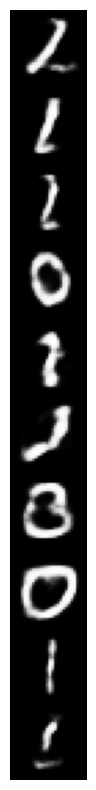

In [146]:
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n,digit_size))
for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size,:] = pred_z_decoded[i, :].reshape(digit_size, digit_size)
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()